# Libraries

In [13]:
import sys
sys.path.append("../")

In [14]:
# for working with data
import pandas as pd
import numpy as np
from src.data_exploration import explore_functions as explr

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

# for preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import WoEEncoder

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# for evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

In [15]:
def check_balance(data, target, chart_types="pie", normalize=True, positive_target=0):
    target_counts = data[target].value_counts()
    target_counts.index = ["non-default" if i==positive_target else "default" for i in target_counts.index] 
    # sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index)
    if chart_types == "pie":
        plt.pie(target_counts.values, labels=target_counts.index, normalize=normalize, startangle=90,
            autopct="%1.1f%%", explode=[0, 0.1])
    elif chart_types == "bar":
        sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette="tab10")
        plt.xlabel("Targets")
    plt.title("Distribution of Targets")

def distribution_barplot(data, feature, normalize=True, title=None, legend="auto", labels=None):
    feature_count = data[feature].value_counts(normalize=normalize).reset_index()
    sns.barplot(x=feature_count[feature], y=feature_count.iloc[:, 1], hue=feature_count.iloc[:, 0],
                palette="Set2", legend=legend)      
    plt.xlabel(feature)
    plt.title(f"Distribution of {feature}")

def distitribution_otherbased(data, dist_feature, base_feature, normalize=False):
    dist = data.groupby(by=base_feature, as_index=False)[dist_feature].value_counts(normalize=normalize)
    sns.barplot(x=dist[base_feature], y=dist.iloc[:, -1], hue=dist[dist_feature])
    if normalize:
        plt.ylim(0, 1.05)

# Load Data

In [16]:
data_org = pd.read_csv("../data/taiwan_default_payments.csv")
data_org.head()

,default,id,limit_bal,gender,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,1,1,20000,female,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,1,2,120000,female,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,3,90000,female,university,single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,4,50000,female,university,married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,5,50000,male,university,married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


# Train Test Split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(data_org.iloc[:, 1:], data_org.iloc[:, 0], test_size=0.2,
                                                    shuffle=True, random_state=42)
print(f"Training Set: {x_train.shape[0]} observations")
print(f"Testing Set: {x_test.shape[0]} observations")

Training Set: 24000 observations
Testing Set: 6000 observations


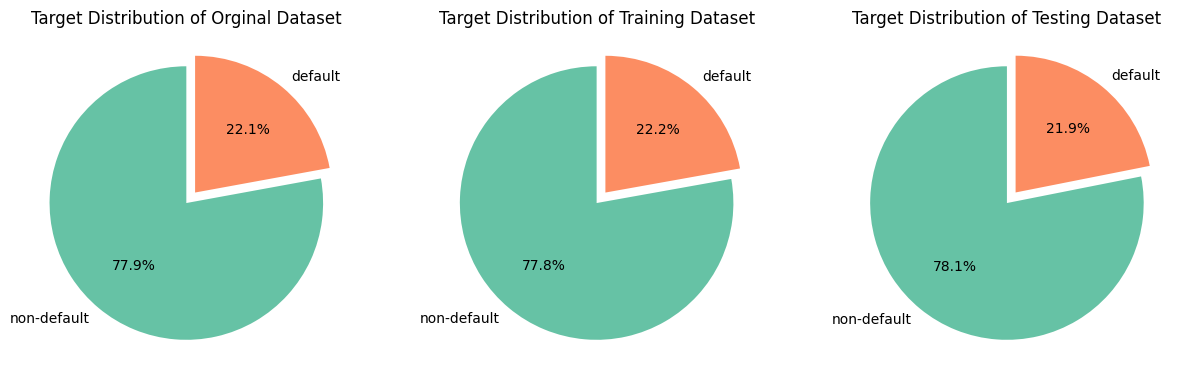

In [18]:
plt.figure(figsize=(15, 5))
dataset = [data_org, pd.DataFrame(y_train), pd.DataFrame(y_test)]
titles = ["Target Distribution of Orginal Dataset",
          "Target Distribution of Training Dataset",
          "Target Distribution of Testing Dataset"]
for i in range(3):
    plt.subplot(1, 3, i+1)
    check_balance(data=dataset[i], target="default")
    plt.title(titles[i])

# Preprocessing

In [7]:
class Preprocessing:
    def __init__(self, scaler=None, encoder=None, numeric_to_object=None,
                 numeric_into_bins=None, bins=None, specific_encoders=None):
        self.scaler = scaler
        self.encoder = encoder
        self.specific_encoders = specific_encoders
        self.numeric_into_bins = numeric_into_bins
        self.num_to_obj = numeric_to_object
        self.numbins = bins
        self.cate_feas = None
        self.num_feas = None
    
    def fit(self, X, y):
        data = X.copy()

        self.cate_feas = self.num_to_obj + self.numeric_into_bins + list(self.specific_encoders.keys())
        self.cate_feas += list(data.select_dtypes(include="object").columns)
        self.num_feas = [col for col in data.columns if col not in self.cate_feas]

        if self.specific_encoders is not None:
            for feature, encoder in self.specific_encoders.items():
                if not isinstance(encoder, OneHotEncoder):
                    if isinstance(encoder, WoEEncoder):
                        self.specific_encoders[feature].fit(data[feature], y)
                    else:
                        self.specific_encoders[feature].fit(data[feature])
        
        data[self.num_feas] = self.scaler.fit(data[self.num_feas])

        if not isinstance(self.encoder, OneHotEncoder):
            if isinstance(self.encoder, WoEEncoder):
                self.encoder.fit(data[self.cate_feas], y)
            else:
                self.encoder.fit(data[self.cate_feas])


        # if self.num_to_obj is not None:
        #     data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        # if self.numeric_into_bins is not None:
        #     for feature in self.numeric_into_bins:
        #         data[f"{feature}_bins"] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])
        #     data = data.drop(self.numeric_into_bins, axis=1)
        
        # if self.specific_encoders is not None:
        #     for feature, encoder in self.specific_encoders.items():
        #         data = self.encoding(X=data, features=[feature], encoder=encoder, update=True)

        # extra_obj = self.num_to_obj + self.numeric_into_bins

        # self.cate_feas = list(data.select_dtypes(include="object").columns)
        # self.num_feas = list(data.select_dtypes(exclude="object").columns)

        # data[self.num_feas] = self.scaler.fit_transform(data[self.num_feas])
        # data = self.encoding(X=data, features=self.cate_feas, encoder=self.encoder, update=True)

    def fit_transform(self, X):
        self.fit(X)
        data = self.transform(X)
        return data
        
        data = X.copy()

        if self.num_to_obj is not None:
            data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        if self.numeric_into_bins is not None:
            for feature in self.numeric_into_bins:
                data[f"{feature}_bins"] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])
            data = data.drop(self.numeric_into_bins, axis=1)

        if self.specific_encoders is not None:
            for feature, encoder in self.specific_encoders.items():
                if isinstance(encoder, OneHotEncoder):
                    encoded = pd.get_dummies(data[feature], dtype=int)
                    data = data.drop(feature, axis=1)
                    data = pd.concat([data, encoded], axis=1)
                else:
                    data[feature] = self.specific_encoders[feature].transform(data[feature])

        data[self.num_feas] = self.scaler.transform(data[self.num_feas])

        if isinstance(self.encoder, OneHotEncoder):
            data = pd.get_dummies(data, dtype=int)
        else:
            data[self.cate_feas] = self.encoder.fit(data[self.cate_feas])



    def transform(self, X):
        data = X.copy()

        if self.num_to_obj is not None:
            data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        if self.numeric_into_bins is not None:
            for feature in self.numeric_into_bins:
                data[f"{feature}_bins"] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])
            data = data.drop(self.numeric_into_bins, axis=1)

        if self.specific_encoders is not None:
            for feature, encoder in self.specific_encoders.items():
                if isinstance(encoder, OneHotEncoder):
                    encoded = pd.get_dummies(data[feature], dtype=int)
                    data = data.drop(feature, axis=1)
                    data = pd.concat([data, encoded], axis=1)
                else:
                    data[feature] = self.specific_encoders[feature].transform(data[feature])

        data[self.num_feas] = self.scaler.transform(data[self.num_feas])

        if isinstance(self.encoder, OneHotEncoder):
            data = pd.get_dummies(data, dtype=int)
        else:
            data[self.cate_feas] = self.encoder.fit(data[self.cate_feas])

        return data

    def convert_into_bins(self, X, feature, bins):
        data = X.copy()
        for bins, bins_name in bins.items():
            data.loc[data[feature].between(bins[0], bins[1], "right"), f"{feature}_bins"] = bins_name
        return data.iloc[:, -1]

In [8]:
preprocessor = Preprocessing(numeric_into_bins=["age"], bins={"age": {(0, 20): "under 20",
                                                                      (20, 30): "20-30",
                                                                      (30, 40): "30-40",
                                                                      (40, 50): "40-50",
                                                                      (50, 60): "50-60",
                                                                      (60, 100): "over 60"}})
preprocessor.transform(x_train)

,id,limit_bal,gender,education,marriage,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,age_bins
21753,21754,80000,female,university,single,0,0,0,0,0,0,75125,77353,78321,73731,39643,39457,3503,5001,2092,1218,1445,878,20-30
251,252,30000,male,university,single,0,0,0,0,0,0,29242,29507,29155,25255,22001,0,5006,1244,851,955,0,0,20-30
22941,22942,180000,female,others,married,0,0,-1,-1,-1,-1,20916,0,850,0,6881,10340,0,850,0,6881,10340,182,40-50
618,619,60000,male,graduate school,single,0,0,0,0,0,0,58839,53235,38533,39639,39619,39140,2018,1900,2000,1500,1900,2000,20-30
17090,17091,130000,female,university,single,0,0,0,0,0,0,111587,112348,114734,117823,120854,123904,4100,4200,5000,5000,5000,10700,20-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,29803,50000,male,university,single,0,0,0,0,0,0,52475,53600,55739,55957,29238,6119,2000,3000,1591,72,1134,73421,30-40
5390,5391,200000,male,graduate school,single,2,2,2,2,2,2,157131,166590,168386,164182,169029,172084,13500,6000,0,7500,6000,4000,30-40
860,861,50000,male,graduate school,single,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,20-30
15795,15796,70000,female,university,single,0,0,0,0,2,2,73939,70488,51152,35122,28633,28039,3000,2000,4500,1200,0,1200,20-30


In [9]:
pd.qcut(x_train["bill_amt1"], q=5)
x_train["bill_amt1"].value_counts(bins=3).index[0]

Interval(-166710.09199999998, 211117.0, closed='right')

In [10]:
x_train[[f'bill_amt{i}' for i in range(1, 7)]].max().max()

1664089

In [11]:
data_org.describe()

,default,id,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,0.221200,15000.500000,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,0.415062,8660.398374,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,1.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,0.000000,7500.750000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,0.000000,15000.500000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,0.000000,22500.250000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1.000000,30000.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [12]:
pd.get_dummies(x_train, dtype=int)

,id,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,gender_female,gender_male,education_graduate school,education_high school,education_others,education_university,marriage_married,marriage_others,marriage_single
21753,21754,80000,24,0,0,0,0,0,0,75125,77353,78321,73731,39643,39457,3503,5001,2092,1218,1445,878,1,0,0,0,0,1,0,0,1
251,252,30000,28,0,0,0,0,0,0,29242,29507,29155,25255,22001,0,5006,1244,851,955,0,0,0,1,0,0,0,1,0,0,1
22941,22942,180000,44,0,0,-1,-1,-1,-1,20916,0,850,0,6881,10340,0,850,0,6881,10340,182,1,0,0,0,1,0,1,0,0
618,619,60000,25,0,0,0,0,0,0,58839,53235,38533,39639,39619,39140,2018,1900,2000,1500,1900,2000,0,1,1,0,0,0,0,0,1
17090,17091,130000,25,0,0,0,0,0,0,111587,112348,114734,117823,120854,123904,4100,4200,5000,5000,5000,10700,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,29803,50000,32,0,0,0,0,0,0,52475,53600,55739,55957,29238,6119,2000,3000,1591,72,1134,73421,0,1,0,0,0,1,0,0,1
5390,5391,200000,37,2,2,2,2,2,2,157131,166590,168386,164182,169029,172084,13500,6000,0,7500,6000,4000,0,1,1,0,0,0,0,0,1
860,861,50000,26,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
15795,15796,70000,25,0,0,0,0,2,2,73939,70488,51152,35122,28633,28039,3000,2000,4500,1200,0,1200,1,0,0,0,0,1,0,0,1


In [28]:
x = data_org.select_dtypes(exclude="object")
scaler = StandardScaler()
scaler.fit_transform(x)

array([[ 1.87637834, -1.73199307, -1.13672015, ..., -0.30806256,
        -0.31413612, -0.29338206],
       [ 1.87637834, -1.7318776 , -0.3659805 , ..., -0.24422965,
        -0.31413612, -0.18087821],
       [-0.53294156, -1.73176213, -0.59720239, ..., -0.24422965,
        -0.24868274, -0.01212243],
       ...,
       [ 1.87637834,  1.73176213, -1.05964618, ..., -0.03996431,
        -0.18322937, -0.11900109],
       [ 1.87637834,  1.7318776 , -0.67427636, ..., -0.18512036,
         3.15253642, -0.19190359],
       [ 1.87637834,  1.73199307, -0.90549825, ..., -0.24422965,
        -0.24868274, -0.23713013]])

In [78]:
LabelEncoder().fit_transform(x_train['gender'])

array([0, 1, 0, ..., 1, 0, 0])